In [1]:
import os
HOME = os.getcwd()
print(HOME)

/root


In [2]:
if not os.path.exists("TrackNetV3"):
    !git clone https://github.com/lu-joseph/TrackNetV3
%cd {HOME}/TrackNetV3
if not os.path.exists("ckpts"):
    !wget --no-check-certificate 'https://drive.usercontent.google.com/download?id=1CfzE87a0f6LhBp0kniSl1-89zaLCZ8cA&export=download&authuser=0&confirm=t&uuid=fd5c99d1-dc6a-4011-948b-1d03be7d6628&at=AN_67v1rreyiyg-hMrVlkh9Np5is%3A1729497024731' -O TrackNetV3_ckpts.zip
    !unzip TrackNetV3_ckpts.zip
%cd {HOME}

/root/TrackNetV3
/root


In [2]:
%cd {HOME}/TrackNetV3
!pip install -r requirements.txt
%cd {HOME}

/root/TrackNetV3
/root


## Predict Video

In [4]:
%cd {HOME}/TrackNetV3
from predict import predict_video
video_file = "../rally.mp4"
tracknet_file = "ckpts/TrackNet_best.pt"
inpaintnet_file = "ckpts/InpaintNet_best.pt"

# predict_video(
#     video_file=video_file,
#     tracknet_file=tracknet_file,
#     inpaintnet_file=inpaintnet_file,
#     batch_size=5)


/root/TrackNetV3


/root/TrackNetV3/predict.py:96: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  tracknet_ckpt = torch.load(tracknet_file)
/root/TrackNetV3/predict.py:103: FutureWarning: You a

Done.


## Splitting video into shots

In [24]:
%cd {HOME}
import supervision as sv

video_info = sv.VideoInfo.from_video_path(video_path="rally.mp4")

for idx,shot_idx in enumerate(mid_shot_frames):
    start_frame = max(shot_idx-10,0)
    end_frame = min(shot_idx+10,video_info.total_frames - 1)
    total_frames = end_frame - start_frame + 1
    shot_video_info = sv.VideoInfo(width=video_info.width,height=video_info.height,fps=video_info.fps,total_frames=total_frames)
    with sv.VideoSink(target_path=f'output/shot{idx}.mp4',video_info=shot_video_info, codec="mp4v") as sink:
        for frame in sv.get_video_frames_generator(source_path="rally.mp4",start=start_frame,end=end_frame):
            sink.write_frame(frame)
    print(f'done shot {idx}',end='\r')

/root


## Tracking players
Tracking only nearside player

### Skeleton joint ids:
0: Nose 1: Left Eye 2: Right Eye 3: Left Ear 4: Right Ear 5: Left Shoulder 6: Right Shoulder 7: Left Elbow 8: Right Elbow 9: Left Wrist 10: Right Wrist 11: Left Hip 12: Right Hip 13: Left Knee 14: Right Knee 15: Left Ankle 16: Right Ankle

In [20]:
%cd {HOME}
import supervision as sv

# def callback(frame, _):
#     path = get_court_path(frame, 'near-side')
#     pose_results = get_pose_results_for_path(frame, path)
#     if not pose_results: return frame
#     img = pose_results.plot(boxes=False)
#     return img

# sv.process_video(source_path='./rally.mp4', target_path='./output/rally_annotated.mp4', callback=callback)

/root


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x7140fe00] moov atom not found


Exception: Could not open video at ./output/rally_annotated.mp4

## Annotating clip

In [18]:
%cd {HOME}
import supervision as sv

# box_annotator = sv.BoxAnnotator()
# def callback(frame, idx):
#     # x,y = frame_to_xy[idx]
#     # color = Color(r=255,g=0,b=0) if idx in shot_frames else Color(r=0,g=255,b=0)
#     # annotated_frame = draw_rects(frame, [Rect(x-10,y-10,20,20)],color=color)
#     # return annotated_frame
#     results = pose_model(frame)[0]
#     detections = detections_from_yolov11(results)
#     annotated_frame = box_annotator.annotate(scene=frame.copy(), detections=detections)
#     path = get_court_path(frame, 'near-side')
#     pose_results = get_pose_results_for_path(frame, path)
#     return pose_results.plot(boxes=False)

# vid = "./output/annotated.mp4"

# sv.process_video(source_path="./rally.mp4", target_path=vid, callback=callback)

/root

0: 384x640 5 persons, 48.7ms
Speed: 1.4ms preprocess, 48.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


## Plotting Shuttle Trajectory

/root


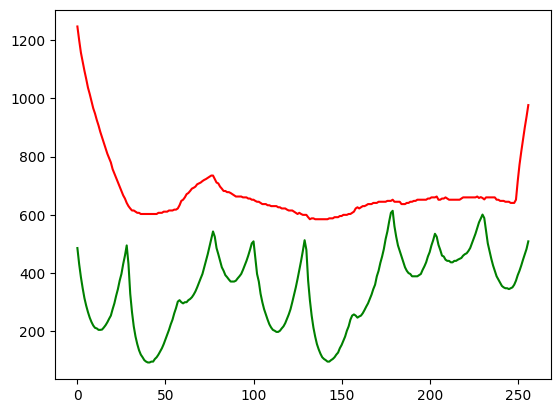

In [16]:
%cd {HOME}
import matplotlib.pyplot as plt
import numpy as np
from courtiq_utils import get_frame_xys_from_csv


# frame_to_xy = get_frame_xys_from_csv('TrackNetV3/pred_result/rally_ball.csv')

# frame = np.arange(len(frame_to_xy))
# x = [f[0] for f in frame_to_xy.values()]
# y = [f[1] for f in frame_to_xy.values()]
# y_1 = np.gradient(y)
# y_2 = np.gradient(y_1)


# plt.plot(frame, x,color="red")
# plt.plot(frame, y,color="green")
# plt.show()


## Plotting player arm during shot

/root
shot happens at frame 129


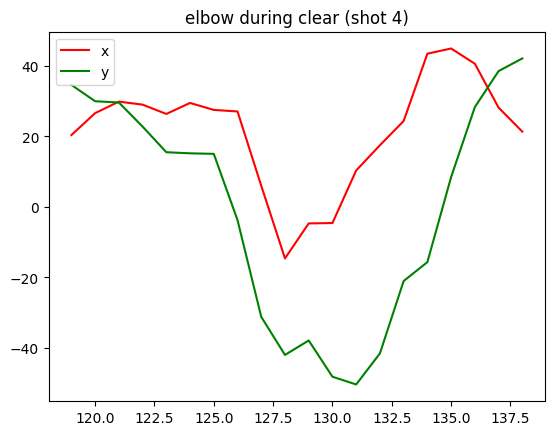

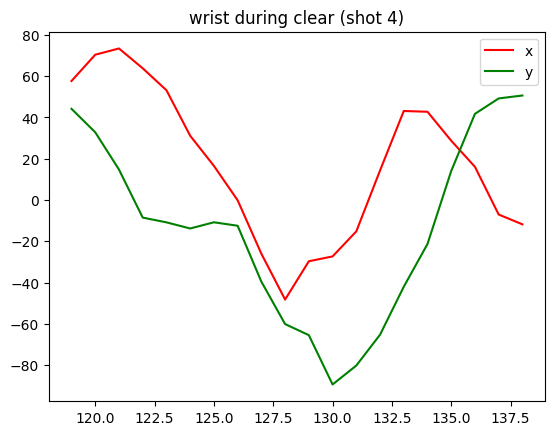

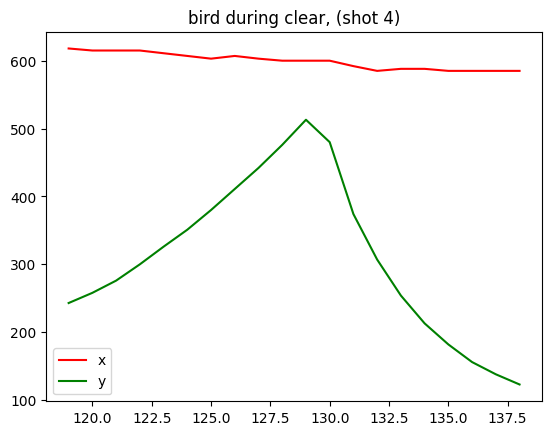

In [3]:
%cd {HOME}
import supervision as sv
from courtiq_utils import get_shot_frames_from_xys, get_frame_xys_from_csv, get_xys_for_shot_frame, plot_limb, get_bird_xys_for_shot_frame

shot_idx = 4
csv = "./TrackNetV3/pred_result/rally_ball.csv"
type_of_shot = "clear"

frame_xys = get_frame_xys_from_csv(csv)
shot_frames = get_shot_frames_from_xys(frame_xys)
shot_frame_idx = shot_frames[shot_idx]
print(f'shot happens at frame {shot_frame_idx}')
right_elbow, right_wrist = get_xys_for_shot_frame(shot_frame_idx)
bird = get_bird_xys_for_shot_frame(shot_frame_idx, frame_xys)


plot_limb(right_elbow, shot_frame_idx, f'elbow during {type_of_shot} (shot {shot_idx})')
plot_limb(right_wrist, shot_frame_idx, f'wrist during {type_of_shot} (shot {shot_idx})')
plot_limb(bird, shot_frame_idx, f'bird during {type_of_shot}, (shot {shot_idx})')

